Taken from: https://math.stackexchange.com/questions/2013050/log-of-softmax-function-derivative

The derivation of the softmax score function (aka eligibility vector) is as follows:  
  
First, note that:  
#### $$\pi_\theta(s,a) = softmax =\frac{e^{\phi(s,a)^\intercal\theta}}{\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta}}$$  
The important bit here is that the slide only identifies the proportionality, not the full softmax function which requires the normalization factor.  
  
Continuing the derivation:  
  
Using the log identity $\log(x/y) = \log(x) - \log(y)$ we can write  
#### $$\log(\pi_\theta(s,a)) = \log(e^{\phi(s,a)^\intercal\theta}) - \log(\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta})$$  
  
Now take the gradient:  
#### $$\nabla_\theta\log(\pi_\theta(s,a)) = \nabla_\theta\log(e^{\phi(s,a)^\intercal\theta}) - \nabla_\theta\log(\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta})$$  
  
The left term simplifies as follows:  
  
#### $$left= \nabla_\theta\log(e^{\phi(s,a)^\intercal\theta}) = \nabla_\theta\phi(s,a)^\intercal\theta = \phi(s,a)$$
  
The right term simplifies as follows:  
  
Using the chain rule:  
#### $$\nabla_x\log(f(x)) = \frac{\nabla_xf(x)}{f(x)}$$
  
We can write:  
  
#### $$right = \nabla_\theta\log(\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta}) = \frac{\nabla_\theta\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta}}{\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta}}$$  

Taking the gradient of the numerator we get:  
  
#### $$right = \frac{\sum_{k=1}^N{\phi(s,a_k)}e^{\phi(s,a_k)^\intercal\theta}}{\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta}}$$
Substituting the definition of $\pi_\theta(s,a)$ we can simplify to:  
  
#### $$right = \sum_{k=1}^N{\phi(s,a_k)}\pi_\theta(s,a_k)$$  
Given the definition of Expected Value:  
  
#### $$\mathrm{E}[X] = X \cdot P = x_1p_1+x_2p_2+ ... +x_np_n$$
Which in English is just the sum of each feature times its probability.  
  
####$$X = features = {\phi(s,a)}$$  
####$$P = probabilities =\pi_\theta(s,a)$$  
So now we can write the expected value of the features:  
  
#### $$right = \mathrm{E}_{\pi_\theta}[\phi(s,\cdot)]$$  
Putting it all together:  
#### $$\nabla_\theta\log(\pi_\theta(s,a)) = left - right = \phi(s,a) - \mathrm{E}_{\pi_\theta}[\phi(s,\cdot)]$$

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import gym as gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
import cv2 as cv2
import random
import tensorflow.contrib.eager as tfe
import tensorflow as tf
tf.enable_eager_execution()
%matplotlib inline

from utils.plotting import RewardHistory


/home/william/anaconda3/envs/dev/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# An agent that samples randomly generated weights until it can do 200 episodes

In [ ]:
class RandomAgent():
    def __init__(self):
        self._weights = np.random.uniform(-1, 1, 4)
        self.env = gym.make('CartPole-v0')
        
    def get_action(self, s):
        result = np.matmul(self._weights, s)
        if result > 0:
            return 1
        else:
            return 0
    def randomize(self):
        self._weights = np.random.uniform(-1, 1, 4)
    
    def train(self, episodes=1):
        for episode in range(episodes):
            s = self.env.reset()
            steps = 0
            solved = False
            self.randomize() # randomize weights for each episode
            while True:
                action = self.get_action(s)
                s, reward, done, info = self.env.step(action)
                steps += 1
                if steps == 200:
                    solved = True
                if done:
                    print("Episode finished after {} timesteps".format(steps))
                    break
            if solved == True:
                print("Solved")
                break;
    
    def run(self):
        self.env = gym.make('CartPole-v0')
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.get_action(s)
            s, reward, done, info = self.env.step(action)
            steps += 1
            if done:
                print("Episode finished after {} timesteps".format(steps))
                break
        self.env.close()

agent = RandomAgent()
agent.train(2)

In [ ]:
agent.run()

# Policy Gradient  - raw with np only

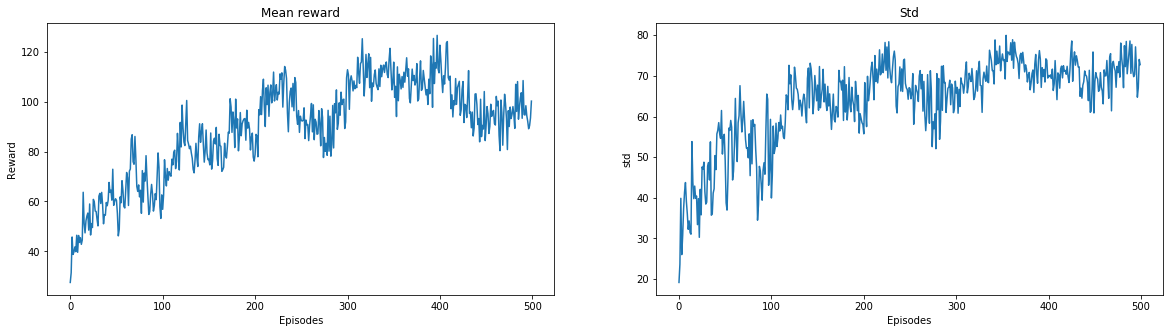

In [72]:
class Agent():
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.episode_durations = []
        self.episode_loss = []
        self.theta = np.random.randn(2, 4)
        self.learning_rate = 0.1
        
        
    def getAction(self, s):
        action_prob = self.softmax(self.theta.dot(s))
        action = np.random.choice([0, 1], p=action_prob)
        return action
    
    def softmax(self, x):
        top = np.exp(x)
        bottom = top.sum()
        return top/bottom
    
    def train(self, episodes=2):
        # Store cumulative returns for each time step
        all_returns = [[] for _ in range(200)]
        
        for i in range(episodes):
            s = self.env.reset()
            steps = 0
            s_mem = []
            a_mem = []
            r_mem = []
            
            while True:
                action = self.getAction(s)
                
                s_1, reward, done, info = self.env.step(action)
                s_mem.append(s)
                a_mem.append(action)
                r_mem.append(reward)
                
                s = s_1
                
                steps += 1
                if done:
#                     print("Episode finished succe/ssfully after {} timesteps".format(steps))
                    break
            
            R = 0.
            grad = np.zeros_like(self.theta)
            for t in reversed(range(len(s_mem))):
                s_t = s_mem[t]
                a_t = a_mem[t]
                r_t = r_mem[t]
                R = 0.9 * R + r_t
                all_returns[t].append(R)
                if len(all_returns[t]) > 0:
                    b_t = np.mean(all_returns[t])
                
                a = np.zeros(self.theta.shape[0])
                a[a_t] = 1
                p = self.softmax(self.theta.dot(s_t))
                gradient = np.outer(a - p, s_t)
                b_t = 0 # without a baseline it takes a long time to learn
                gradient = gradient * (R - b_t)
                
                grad += gradient
                
#             grad = grad / (np.linalg.norm(grad) + 1e-8)
            self.theta += self.learning_rate * grad
            
            self.episode_durations.append(steps)
    
    def run(self):
        self.env = gym.make('CartPole-v0')
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getAction(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            steps += 1
            if done:
                print("Episode finished successfully after {} timesteps".format(steps))
                break
        self.env.close()

agent = Agent()

reward_history = RewardHistory()
for i in range(10):
    agent = Agent()
    agent.train(500)
    reward_history.append(agent.episode_durations)

reward_history.plot()

In [ ]:
agent.run()

# Policy Gradient with a model

In [ ]:
tf.log([[0.5, 0.5], [0.2, 0.8]])

In [31]:
# import tensorflow.contrib.eager as tfe

class LinearModel(tf.keras.Model):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)

    def call(self, inputs):
        result = self.dense1(inputs)
        return result
    
    
    def loss(self, inputs, targets):
        y = self(inputs)
        loss = y * tf.cast(targets, dtype="float32")
        loss = tf.reduce_sum(loss, reduction_indices=1)
#         print(loss.shape)
        loss = tf.log(loss)
        return loss

    def grad(self, inputs, targets, reward):
        with tfe.GradientTape() as tape:
            loss_value = - tf.reduce_mean(self.loss(inputs, targets) * reward)
        return tape.gradient(loss_value, self.variables)
    
    def train(self, optimizer, inputs, targets, reward):
        grads = self.grad(inputs, targets, reward)
        optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
    

model = LinearModel()

batch = tf.random_uniform([3, 4])
print("batch:", batch)

reward = tf.constant([5., 5., 5.])
reward = tf.expand_dims(reward, axis=1)
print("reward:", reward)

result = model(batch)
print("result:", result)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

num_epochs = 5

for epoch in range(num_epochs):

#     y = tf.constant([[0], [1]], dtype="int32")
    y = tf.one_hot([0, 1, 1], depth=2, dtype="int32")
#     y = tf.constant([1, 0, 1], dtype="int32")

    # Optimize the model
    grads = model.grad(batch, y, reward)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())
        
model(batch)

batch: tf.Tensor(
[[0.559144   0.19631195 0.87052    0.23716342]
 [0.30871356 0.77397203 0.96706986 0.14928174]
 [0.08657956 0.522606   0.7447022  0.19260502]], shape=(3, 4), dtype=float32)
reward: tf.Tensor(
[[5.]
 [5.]
 [5.]], shape=(3, 1), dtype=float32)
result: tf.Tensor(
[[0.2672765  0.73272353]
 [0.5638445  0.43615544]
 [0.57908887 0.42091122]], shape=(3, 2), dtype=float32)


<tf.Tensor: id=7053, shape=(3, 2), dtype=float32, numpy=
array([[0.23536828, 0.76463175],
       [0.50065804, 0.499342  ],
       [0.5214315 , 0.4785685 ]], dtype=float32)>

In [29]:
Transition = namedtuple("Transition", ["s", "a", "s1", "r"])

class PolicyGradientMemory():
    def __init__(self, gamma = 0.9):
        self.memory = []
        self.gamma = gamma
    
    def reset(self):
        self.memory = []
    
    def append(self, transition):
        self.memory.append(transition)
        
    
    def sample(self):
        batched = Transition(*zip(*self.memory))
        s = np.array(list(batched.s), dtype="float32")
        a = np.array(list(batched.a))
        s1 = np.array(list(batched.s1))
        r = np.array(list(batched.r), dtype="float32")
        
        reward = 0.
        for i in reversed(range(len(r))):
            moving_reward = self.gamma * reward
            reward = r[i] + moving_reward
            r[i] = reward
#             print(i, len(r)-i-1, r[i])
#         r = np.expand_dims(r, axis=1)
        return [s, a, s1, r]
    
    def __len__(self):
        return len(self.memory)
    
    def __str__(self):
        result = []
        for i in range(self.__len__()):
            result.append(self.memory[i].__str__() + " \n")
        return "".join(result)

memory = PolicyGradientMemory()

memory.append(Transition([1, 2, 3], 1, [4, 5, 6], 1))
memory.append(Transition([1, 2, 3], 0, [4, 5, 6], 1))
memory.append(Transition([1, 2, 3], 0, [4, 5, 6], 1))
memory.append(Transition([1, 2, 3], 1, [4, 5, 6], 1))
memory.append(Transition([1, 2, 3], 1, [4, 5, 6], 1))





# print(memory)
a = memory.sample()
print("s:", a[0])
print("a:", a[1])
print("s1:", a[2])
print("r:", a[3])




s: [[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]
a: [1 0 0 1 1]
s1: [[4 5 6]
 [4 5 6]
 [4 5 6]
 [4 5 6]
 [4 5 6]]
r: [4.0951 3.439  2.71   1.9    1.    ]


# Ok, now we do Policy Gradient

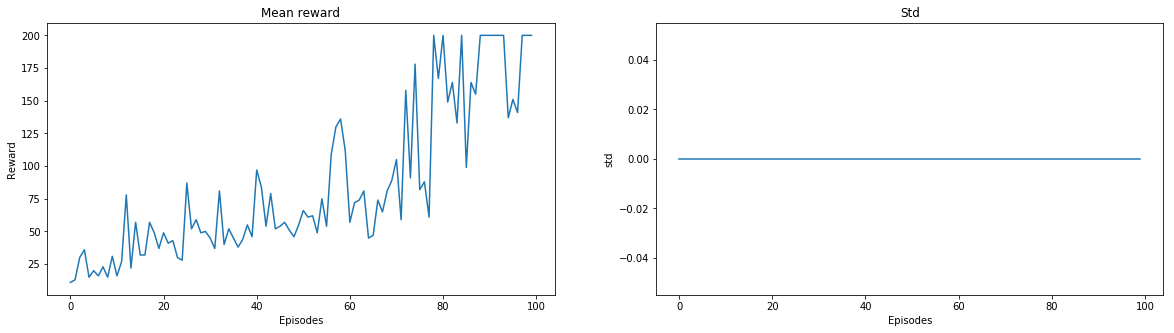

In [71]:
class Agent():
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.episode_durations = []
        self.episode_loss = []
        self.model = LinearModel()
        self.memory = PolicyGradientMemory()
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
        
    def getAction(self, s):
        s = tf.convert_to_tensor([s], dtype=tf.float32)
        action_probability = self.model(s).numpy()
#         print(action_probability)
        action = np.random.choice([0, 1], p=action_probability[0])
        return action
    
    def train(self, episodes=2):
        all_returns = [[] for _ in range(200)]
        for i in range(episodes):
            s = self.env.reset()
            steps = 0
            while True:
                action = self.getAction(s)
                
                s_1, reward, done, info = self.env.step(action)
                self.memory.append(Transition(s, action, s_1, reward))
                s = s_1
                
                steps += 1
                if done:
                    break
        
            
            s, a, s1, r = self.memory.sample()
            a = tf.one_hot(a, depth=2, dtype=tf.int32)
            b = np.zeros_like(r)
            for t in range(len(r)):
                all_returns[t].append(r[t])
                b[t] = np.mean(all_returns[t])
            
            r = tf.constant(r, dtype="float32")
            b = tf.constant(b, dtype="float32")
            
            # Optimize the model
            self.model.train(self.optimizer, s, a, r-b)
            self.memory.reset()

            self.episode_durations.append(steps)
    
    def run(self):
        self.env = gym.make('CartPole-v0')
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getAction(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            steps += 1
            if done:
                print("Episode finished successfully after {} timesteps".format(steps))
                break
        self.env.close()

# agent = Agent()

reward_history = RewardHistory()
for i in range(1):
    agent = Agent()
    agent.train(100)
    reward_history.append(agent.episode_durations)

reward_history.plot()

In [ ]:
###### learner.train(100, show_chart)
for i in range(2):
    agent.run()


# Lessons Learnt


- Adding a baseline made all the difference. Baseline is average of all rewards at that specific time step instead of some arbitrary number or average of the episode or past episodes. 

# Mean reward over 100 training sessions

- REINFORCE without a baseline
![mean reward](./images/REINFORCE_no_baseline.png)

- REINFORCE with a baseline
![mean reward](./images/REINFORCE.png)